In [16]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from tqdm import tqdm

In [23]:
class GridworldEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    """
    This class implements a custom made Gym environment of a NxN Gridworld, where the grid is divided in four rooms which are accessible only from a "door"
    placed on the side of each room.

    The set of states S = {[x,y]| x,y ∈ [0, ..., grid_size]} or {}, represent the possible positions in the environment.
    The set of actions A = [up, down, left, right].
    The transition to a new state T(s_t+1 | s_t, a_t).
    The reward R(s, a) = {1 if s == G else -0.1}.

    In this version the initial state is the position 0 ([0, 0]), I = [0, 0]. The goal state is the position 24 ([4, 4]) G = [4,4].

    Args:
    - grid_size: the size in height and length of the grid, N of the NxN matrix. It must be an even number.
    - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
    - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.

    """

    def __init__(self, grid_size=6, time_horizon=-1, prob=0.1):
        self.grid_size = grid_size
        self.state_space = spaces.Discrete(self.grid_size ** 2)
        self.action_space = spaces.Discrete(4)
        self.reward_range = (-0.1, 1.0)
        self.goal = (grid_size-1, grid_size-1)
        self.current_pos = (0, 0)
        self.done = False
        self.time_horizon = time_horizon
        self.steps_taken = 0
        self.prob = prob
        self.transition_matrix = self._build_transition_matrix()

    def _build_transition_matrix(self):
        '''
        This method builds the transition matrix for the MDP, T(s'|a, s).
        The function should be used with the following order of operands:
         - first parameter: s, the state where the agent takes the action in
         - second parameter: s', the state where the agent arrives taking action a from state s
         - third parameter: a, the action taken by the agent
        '''
        transition_matrix = np.zeros((self.state_space.n, self.state_space.n, self.action_space.n))
        # For every state (i,j)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                s = (i, j)
                # For every action 'a' chosen as action from the agent
                for a in range(self.action_space.n):
                    # For all actions 'a_'
                    for a_ in range(self.action_space.n):
                        # Calculate the probability of
                        prob = 1 - self.prob if a_ == a else self.prob / (self.action_space.n - 1)
                        s_ = self._sample_new_position(a_, s)
                        transition_matrix[self._state_to_index(s), self._state_to_index(s_), a] += prob
        return transition_matrix

    def _sample_new_position(self, action, state):
        if action == 0:  # up
            if state[1] == self.grid_size / 2 and (state[0] not in range(1, self.grid_size - 2)):
                new_pos = state
            else: new_pos = (state[0], max(0, state[1]-1))
        elif action == 1:  # down
            if state[1] == self.grid_size / 2 - 1 and (state[0] not in range(1, self.grid_size - 2)):
                new_pos = state
            else:
                new_pos = (state[0], min(self.grid_size-1, state[1]+1))
        elif action == 2:  # left
            if state[0] == self.grid_size / 2 and (state[1] not in range(1, self.grid_size - 2)):
                new_pos = state
            else:
                new_pos = (max(0, state[0]-1), state[1])
        elif action == 3:  # right
            if state[0] == self.grid_size / 2 - 1 and (state[0] not in range(1, self.grid_size - 2)):
                new_pos = state
            else:
                new_pos = (min(self.grid_size-1, state[0]+1), state[1])
        else:
            raise ValueError("Invalid action.")
        return new_pos

    def _state_to_index(self, state):
        return state[0] + state[1] * self.grid_size

    def _index_to_state(self, index):
        """Converts an index to a state tuple (i, j)."""
        i = index % self.grid_size
        j = index // self.grid_size
        #print("Converting %d => (%d, %d)" %(index, i, j))
        return (i, j)

    def sample_next_state(self, action):
        current_state = self._state_to_index(self.current_pos)
        action_probabilities = self.transition_matrix[current_state, :, action]
        next_state_index = np.random.choice(self.state_space.n, p=action_probabilities)
        next_pos = self._index_to_state(next_state_index)
        #print("Taking action %d from cur_pos index:%d (%d, %d): going to index %d which is state => (%d, %d)" %(action, current_state, self.current_pos[0], self.current_pos[1], next_state_index, next_pos[0], next_pos[1]))
        return next_pos

    def step(self, action):
        #print("Time-step: %d" %self.steps_taken)
        if self.done:
            raise ValueError("Episode has already ended.")
        new_pos = self.sample_next_state(action)
        reward = -0.1  # default reward for moving
        if new_pos == self.goal:
            reward = 1.0
        self.current_pos = new_pos
        self.steps_taken += 1
        if self.time_horizon != -1 and self.steps_taken >= self.time_horizon:
            self.done = True
        return self.current_pos, reward, self.done, {}

    def reset(self, **kwargs):
        self.current_pos = (0, 0)
        self.done = False
        self.steps_taken = 0
        return self.current_pos

    def render(self, mode='human'):
        if mode == 'human':
            for j in range(self.grid_size):
                for i in range(self.grid_size):
                    if (i, j) == self.current_pos:
                        print("X ", end='')
                    elif (i, j) == self.goal:
                        print("G ", end='')
                    else:
                        print("_ ", end='')
                print()
            print()

# Reward Reinforce Agent MDP

In [18]:
# Define the REINFORCE agent
class REINFORCEAgent():
    '''
    This class is the implementation of a REINFORCE agent that tries to maximize the objective function J(θ)=E_(τ ~ p_π)[R(τ)]
    Args:
     - env: the instance of the environment on which the agent is acting.
     - alpha: the value of the learning rate to compute the policy update.
     - gamma: the value of the discount for the reward in order to compute the discounted reward.
    '''
    def __init__(self, env, alpha=0.1, gamma=0.99):
        self.env = env
        self.alpha = alpha  # learning rate
        self.gamma = gamma  # discount factor
        self.policy_params = np.zeros((env.grid_size, env.grid_size, env.action_space.n))

    def get_action(self, state):
        # Sample action from the policy
        params = self.policy_params[state[0], state[1], :]
        probs = np.exp(params) / np.sum(np.exp(params))
        action = np.random.choice(len(probs), p=probs)
        return action

    def compute_returns(self, episode):
        G = 0
        returns = []
        for t in reversed(range(len(episode))):
            _, _, reward, _ = episode[t]
            G = self.gamma * G + reward
            returns.append(G)
        returns = np.array(list(reversed(returns)))
        return returns

    def update_single_sampling(self, episode):
        '''
        This version of the update is the Monte Carlo sampling version of the REINFORCE algorithm.

        Args:
         - episode: the sampled trajectory from which we compute the policy gradient.
        '''
        # Compute returns
        returns = self.compute_returns(episode)

        # Compute the policy gradient
        grad = np.zeros_like(self.policy_params)
        for t in range(len(episode)):
            state, action, _, _ = episode[t]
            params = self.policy_params[state[0], state[1], :]
            probs = np.exp(params) / np.sum(np.exp(params))
            dlogp = np.zeros_like(params)
            for i in range(env.action_space.n):
                dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
            grad[state[0], state[1], :] += dlogp * returns[t]
        # Update the policy parameters
        self.policy_params += self.alpha * grad

    def update_multiple_sampling(self, trajectories):
        '''
        This version of the update takes into consideration the approximation of the gradient by sampling multiple trajectories. Instead
        of working with only one trajectory it works with multiple trajectories in order to have a more accurate representation of the expected
        value of the ∇J(θ).

        Args:
         - trajectories: a list of sampled trajectories from which we compute the policy gradient.

        '''
        # Compute the policy gradient
        grad = np.zeros_like(self.policy_params)
        for episode in trajectories:
            returns = self.compute_returns(episode)
            for t in range(len(episode)):
                state, action, _, _ = episode[t]
                # Compute the policy gradient
                params = self.policy_params[state[0], state[1], :]
                probs = np.exp(params) / np.sum(np.exp(params))
                dlogp = np.zeros_like(params)
                for i in range(env.action_space.n):
                    dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
                grad[state[0], state[1], :] += dlogp * returns[t]
        grad /= len(trajectories)
        # Update the policy parameters
        self.policy_params += self.alpha * grad

# Entropy Reinforce Agent MDP

In [19]:
class REINFORCEAgentE(REINFORCEAgent):
    '''
    This class is the extension of the previous Reinforce agent. The only change is the objective followed by the agent that this time is going
    to be the state-action visitation entropy J(θ) = E_(τ ~ p_π)[H(d_τ(s,a))] .
    '''

    def __init__(self, env, alpha=0.01, gamma=0.8):
        super().__init__(env=env, alpha=alpha, gamma=gamma)
        # Optional initialization to have a non-uniform initial policy
        self.policy_params = self.create_dummy_policy()

    def create_dummy_policy(self):
        params = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
        for i in range(self.env.grid_size):
            for j in range(self.env.grid_size):
                params[i, j, 0] = 1
        return params

    # TODO: maybe change the visualization to a 2d matrix instead of 3d
    def compute_state_distribution(self, _episode):
        _d_t = np.zeros((env.grid_size, env.grid_size))
        for _t in range(len(_episode)):
            s_t, _, _, _ = _episode[_t]
            _d_t[s_t[0]][s_t[1]] += 1
        _d_t /= len(_episode)
        return _d_t

    def update_single_sampling(self, episode):
        # Compute the t-step state distribution for the current policy
        d_t = self.compute_state_distribution(episode)
        # Compute entropy of d_t
        entropy = 0
        for x in np.nditer(d_t):
            entropy = entropy - x * np.log(x) if x != 0 else entropy

        # Update policy parameters using the gradient of the entropy of the t-step state distribution
        grad = np.zeros_like(self.policy_params)
        for t in range(len(episode)):
            state, action, _, _ = episode[t]
            # Compute the policy gradient
            params = self.policy_params[state[0], state[1], :]
            probs = np.exp(params) / np.sum(np.exp(params))
            dlogp = np.zeros_like(params)
            for i in range(env.action_space.n):
                dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
            grad[state[0], state[1], :] += dlogp
        grad *= entropy
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        return entropy, d_t

    def update_multiple_sampling(self, trajectories):
        # Update policy parameters using the approximated gradient of the entropy objective function
        grad = np.zeros_like(self.policy_params)
        entropies = []
        for episode in trajectories:
            # Initialize the gradient of the k-th sampled trajectory
            grad_k = np.zeros_like(self.policy_params)
            # Compute the t-step state distribution for the current policy
            d_t = self.compute_state_distribution(episode)
            # Compute entropy of d_t
            entropy = 0
            for x in np.nditer(d_t):
                entropy = entropy - x * np.log(x) if x != 0 else entropy
            # Compute the gradient
            for t in range(len(episode)):
                state, action, _, _ = episode[t]
                # Compute the policy gradient
                params = self.policy_params[state[0], state[1], :]
                probs = np.exp(params) / np.sum(np.exp(params))
                dlogp = np.zeros_like(params)
                for i in range(env.action_space.n):
                    dlogp[i] = 1.0 - probs[i] if i == action else -probs[i]
                grad_k[state[0], state[1], :] += dlogp
            grad_k *= entropy
            # Sum the k-th gradient to the final gradient
            grad += grad_k
            entropies.append(entropy)
        # Divide the gradient by the number of trajectories sampled
        grad /= len(trajectories)
        # Update the policy parameters
        self.policy_params += self.alpha * grad
        return entropies

100%|███████████████████████████████████████| 2000/2000 [54:43<00:00,  1.64s/it]


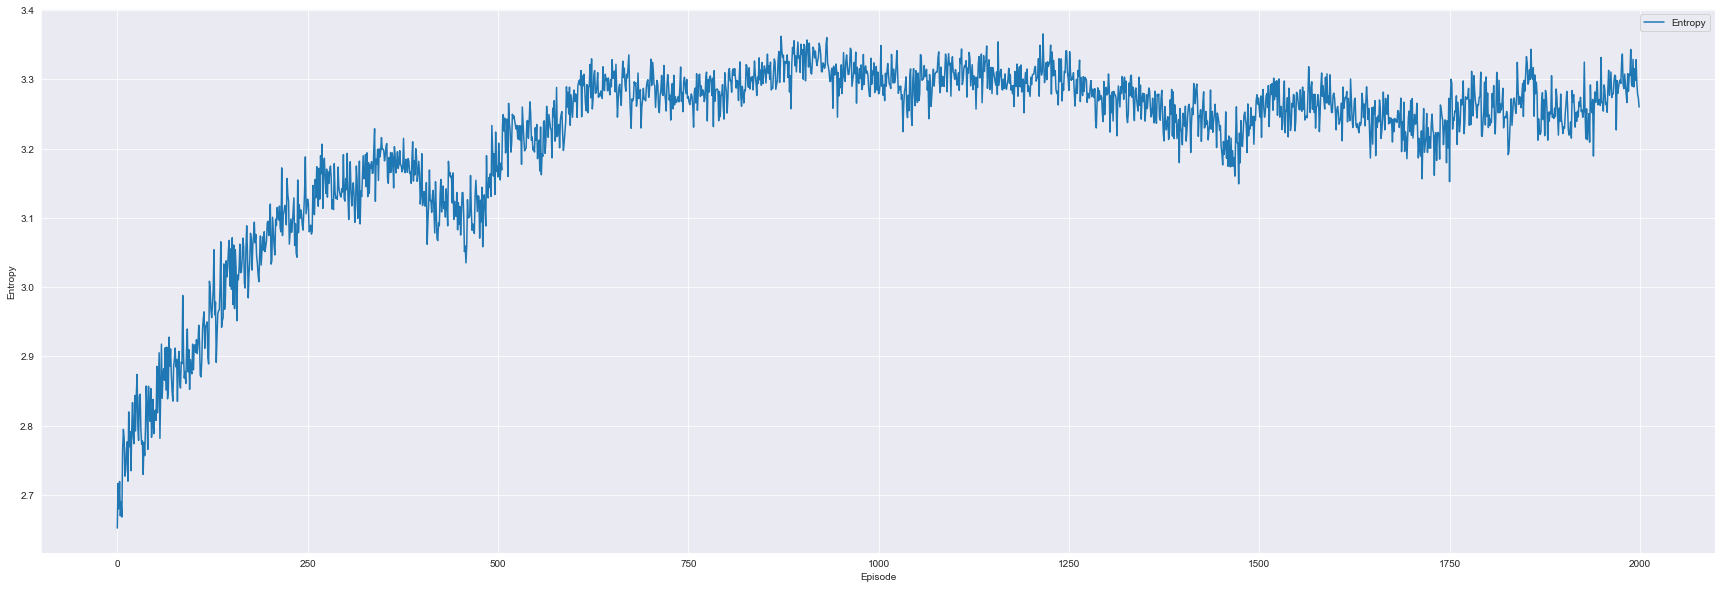

In [41]:
n_episodes = 2000
n_traj = 20
n_run = 1
confidence = 0.95

env = GridworldEnv(time_horizon = 800)

with tqdm(total=n_run * n_episodes, ncols=80) as pbar:
    # Train the agent and plot the entropies
    list_entropies = []
    for r in range(n_run):
        agent = REINFORCEAgentE(env)
        avg_entropies = []
        for i in range(n_episodes):
            episodes = []
            entropies = []
            for k in range(n_traj):
                episode = []
                state = env.reset()
                done = False
                while not done:
                    action = agent.get_action(state)
                    next_state, reward, done, _ = env.step(action)
                    episode.append((state, action, reward, next_state))
                    state = next_state
                episodes.append(episode)
            entropies = agent.update_multiple_sampling(episodes)
            avg_entropies.append(np.mean(entropies))
            pbar.update(1)
        list_entropies.append(avg_entropies)
    list_entropies = np.transpose(np.array(list_entropies), (1,0))

# Initialize the plotting vectors
fig, ax = plt.subplots(figsize=(30,10))
entropies_means = []
under_line = []
over_line = []
for i in range(n_episodes):
    entropies_mean = np.mean(list_entropies[i])
    entropies_std = np.std(list_entropies[i])
    freedom_deg = n_run - 1
    t_crit = np.abs(t.ppf((1 - confidence) / 2, freedom_deg))
    entropies_means.append(entropies_mean)
    under_line.append(entropies_mean - entropies_std * t_crit / np.sqrt(n_run))
    over_line.append(entropies_mean + entropies_std * t_crit / np.sqrt(n_run))
ax.clear()
ax.plot(entropies_means, label='Entropy')
ax.fill_between(np.arange(n_episodes), under_line, over_line, color='b', alpha=0.1)
ax.set_xlabel('Episode')
ax.set_ylabel('Entropy')
ax.legend()
fig.canvas.draw()

Last episode d_t

In [42]:
print(agent.compute_state_distribution(episode))

[[0.00125 0.00875 0.00625 0.00625 0.00125 0.     ]
 [0.005   0.01125 0.02    0.025   0.0075  0.00375]
 [0.01    0.00875 0.02125 0.03625 0.00625 0.00125]
 [0.02125 0.01875 0.0425  0.055   0.03625 0.01375]
 [0.0125  0.035   0.035   0.22125 0.05125 0.0125 ]
 [0.0875  0.03625 0.02625 0.04    0.04    0.035  ]]


<AxesSubplot:>

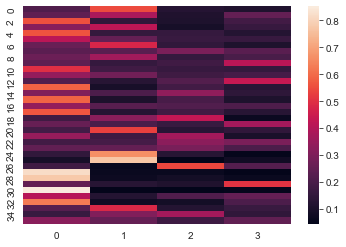

In [43]:
# Prepare the data for heatmap
heatmap_data = np.zeros((env.grid_size**2, env.action_space.n))
for row in range(env.grid_size):
    for col in range(env.grid_size):
        state = row * env.grid_size + col
        for a in range(env.action_space.n):
            prob = np.exp(agent.policy_params[row, col, a]) / np.sum(np.exp(agent.policy_params[row, col]))
            heatmap_data[state, a] = prob
# Plot the heatmap
sns.heatmap(data=heatmap_data, )

# Gridworld POMDP

In [ ]:
class GridworldPOMDPEnv(GridworldEnv):
    '''
    This class implements the extension of the upper Gridworld MDP, making it become a POMDP by inserting the observation mechanism.
    The observations here are modeled as a probability of returning the real state of the MDP, in a Gaussian fashion based on the distance of the observed state from the real current state.

    Args:
     - grid_size: the size in height and length of the grid, N of the NxN matrix.
     - time_horizon: the maximum number of time steps the agent can take to get to the goal. If set to -1 the time horizon is ∞.
     - prob: the probability with which the environment takes the chosen action. If set to 0 the actions taken by the agent are deterministic.
     - steepness: a parameter to control the steepness of the Gaussian distribution that models the observation probability from the real state. A higher value makes it steeper.
    '''
    def __init__(self, grid_size=5, time_horizon=-1, prob=0.1, steepness=15):
        # Initialize the underlying Gridworld MDP
        super().__init__(grid_size=grid_size, time_horizon=time_horizon, prob=prob)
        # Initialize all the POMDP specific variables
        self.observation_space = spaces.Discrete(self.grid_size**2)
        self.steepness = steepness
        self.observation_matrix = self.build_observation_matrix()

    def build_observation_matrix(self):
        '''
        This method creates the observation matrix for our environment.
        The observation function indexes are to be used in order:
         - first param: true state s
         - second param: observation o
        '''
        # Initialize the observation function with zeros
        observation_matrix = np.zeros((self.grid_size**2, self.grid_size**2))
        # Calculate the variance of the Gaussian distribution based on the grid size
        variance = (self.grid_size // 2) ** 2

        for s_i in range(self.observation_space.n):
            for s in range(self.observation_space.n):
                # Calculate the distance between the observed position and the true state
                distance = np.linalg.norm(np.array(self._index_to_state(s_i)) - np.array(self._index_to_state(s)))
                # Assign probability based on Gaussian distribution with adjusted steepness
                observation_matrix[s_i][s] += np.exp(-self.steepness * distance**2 / (2 * variance))
            # Normalize the probabilities for each row
            observation_matrix[s_i] /= np.sum(observation_matrix[s_i])

        # Return the built matrix
        return observation_matrix

    def reset(self):
        # Call the upper reset of the environment
        super().reset()
        # Set the initial belief to a uniform distribution and give it to the agent
        initial_belief = np.ones(self.observation_space.n) / self.observation_space.n
        return initial_belief

    def step(self, action):
        # Make the step of the underlying MDP
        true_state, reward, done, info = super().step(action)
        # Get the index of the state
        true_state_index = self._state_to_index(true_state)
        # Get the observation probabilities for the state
        obs_prob = self.observation_matrix[true_state_index]
        # Sample the next observation from the probabilities
        obs = np.random.choice(self.grid_size**2, p=obs_prob)
        # Change index to position
        obs = self._index_to_state(obs)
        return obs, reward, done, info